# LINGAM for Tabular Causal Discovery

LINGAM can be used for causal discovery in tabular data. The algorithm works by first performing independent component analysis (ICA) on the 
observational data matrix X (#variables x #samples) to extract the mixing matrix A over the independent components (noise matrix) E (same size as X), i.e. solving X=AE. 
Then their algorithm uses the insight that to find the causal order, each sample x can be decomposed as, x = Bx + e, where B is a lower triangular 
matrix and e are the independent noise samples. Noticing that B = (I - A^-1), we solve for B, and find the permutation matrix P, such that PBP' is 
as close to a lower triangular matrix as possible.

This algorithm makes the following assumptions: 
1. linear relationship between variables, 
2. non-Gaussianity of the error (regression residuals), 
3. The causal graph is a DAG, 
4. no hidden confounders. We do not support multi-processing for this algorithm.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import pickle as pkl
import time


In [2]:
from causalai.models.tabular.lingam import LINGAM

from causalai.data.data_generator import DataGenerator
# also importing data object, data transform object, and prior knowledge object, and the graph plotting function
from causalai.data.tabular import TabularData
from causalai.data.transforms.tabular import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall, get_precision_recall_skeleton, make_symmetric

## Load and Visualize Data

Load the dataset and visualize the ground truth causal graph. For the purpose of this example, we will use a synthetic dataset available in our repository.

In [3]:
fn = lambda x:x
coef = 0.1
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 5000

# var_names = [str(i) for i in range(5)]
# sem = GenerateRandomTabularSEM(var_names=var_names, max_num_parents=2, seed=1)
data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False,
                                                noise_fn=[np.random.rand]*len(sem.keys()))
# data_array = np.random.randn(T, 7)
# var_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

graph_gt

{'a': [],
 'b': ['a', 'f'],
 'c': ['b', 'f'],
 'd': ['b', 'g'],
 'e': ['f'],
 'f': [],
 'g': []}

Now we perform the following operations:

1. Standardize the data arrays
2. Create the data object

In [4]:


# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TabularData(data_trans, var_names=var_names)



We visualize the data and graph below:

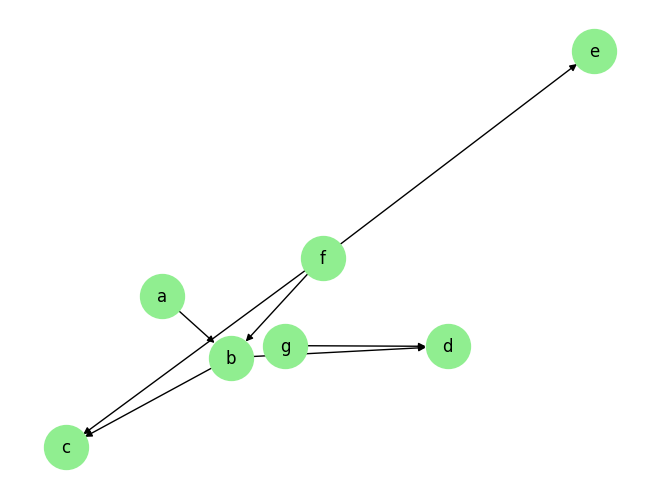

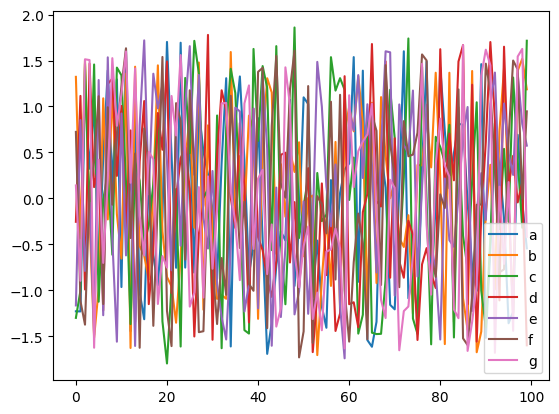

In [5]:


plot_graph(graph_gt, node_size=1000)



for i, n in enumerate(var_names):
    plt.plot(data_trans[-100:,i], label=n)
plt.legend()
plt.legend()
plt.show()

## Causal Discovery (CD)

For LINGAM algorithm, causal discovery can be performed for the whole graph (Full Causal Discovery). Targeted causal discovery (finding parents of a specific target variable) is not supported like some of the other algorithms in our library.

Multiprocessing is not supported in LINGAM.

Prior Knowledge is supported in LINGAM.


### Full Causal Discovery

In [6]:

prior_knowledge = None #  PriorKnowledge(forbidden_links={'f': ['e']})

lingam = LINGAM(
        data=data_obj,
        prior_knowledge=prior_knowledge
        )


In [7]:
tic = time.time()
result = lingam.run(pvalue_thres=0.01)
toc = time.time()
print(f'Time taken: {toc-tic:.2f}s\n')


print(f' The output result has keys: {result.keys()}')
print(f' The output result["a"] has keys: {result["a"].keys()}')

Time taken: 0.17s

 The output result has keys: dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
 The output result["a"] has keys: dict_keys(['value_dict', 'pvalue_dict', 'parents'])


The output _result_ has the variable names as its keys, and the value corresponding to each key is a dictionary with 3 keys, parents, value_dict and pvalue_dict. The first one is a list of the causal parents. The dictionary result['value_dict'] contains the strength of the link between the targeted variable and each of the candidate parents. The dictionary result['pvalue_dict'] contains the p-values of the said strength.

In [8]:
print(f'Predicted parents:')
graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')

print(f"\nGround truth parents:")  
for key in graph_gt.keys():
    print(f'{key}: {graph_gt[key]}')

precision, recall, f1_score = get_precision_recall(graph_est, graph_gt)
print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Predicted parents:
a: []
b: ['f', 'a']
c: ['f', 'b']
d: ['g', 'b']
e: ['f']
f: []
g: []

Ground truth parents:
a: []
b: ['a', 'f']
c: ['b', 'f']
d: ['b', 'g']
e: ['f']
f: []
g: []
Precision 1.00, Recall: 1.00, F1 score: 1.00


In general, we find that for tabular data, edge orientation in the causal discovery process is not as reliable as that in the case of time series data. This is because in time series, edges always go from past to future. But such information is absent in tabular data, which makes the edge orintation problem harder.

However, we find that this is not for LIGAM algorithm, which recovers the edge orientation much more reliably compared to the other algorithms supported by CausalAI. Note however, that this is not a fair comparision because most of the other algorithms for continuous data assume Gaussian noise as opposed to non-Gaussian noise, which is the case for LINGAM.
